In [3]:
import os
import zipfile
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from keras.optimizers import Adam
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [6]:
from zipfile import ZipFile
with ZipFile('D:/CorelDataset.zip', 'r') as zipObj:
    zipObj.extractall('Corel')

In [1]:
dataset_path='C:/Users/Madhusmita Das/Downloads/Corel/dataset'

In [4]:
# Define image dimensions
img_width, img_height = 224, 224  # Standard for ResNet50

# Create data generators with train-test split (80% train, 20% test)
train_datagen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_dir = os.path.join(dataset_path, 'training_set')  # Assuming train folder is created after splitting
test_dir = os.path.join(dataset_path, 'test_set')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=8,  # Adjust batch size based on GPU memory
    class_mode='categorical',  # Multi-class classification
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=8,
    class_mode='categorical',
    shuffle=False  # Maintain order for retrieval
)

Found 900 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


In [5]:
import matplotlib.pyplot as plt

Epoch 1/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 464ms/step - accuracy: 0.0850 - loss: 2.4383 - val_accuracy: 0.1300 - val_loss: 2.1440
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 54s 468ms/step - accuracy: 0.2415 - loss: 2.1075 - val_accuracy: 0.3000 - val_loss: 2.0322
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 51s 445ms/step - accuracy: 0.3325 - loss: 1.9755 - val_accuracy: 0.4100 - val_loss: 1.8635
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 51s 448ms/step - accuracy: 0.3859 - loss: 1.8635 - val_accuracy: 0.4600 - val_loss: 1.8085
Epoch 5/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.3877 - loss: 1.8225 - val_accuracy: 0.4500 - val_loss: 1.7647
Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 92s 610ms/step - accuracy: 0.4685 - loss: 1.7097 - val_accuracy: 0.1700 - val_loss: 3.0047
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 571ms/step - accuracy: 0.5816 - loss: 1.2020 - val_accuracy: 0.3200 - val_loss: 2.7202
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 84s 737ms/step - accuracy: 0.7300 - loss: 0.8549

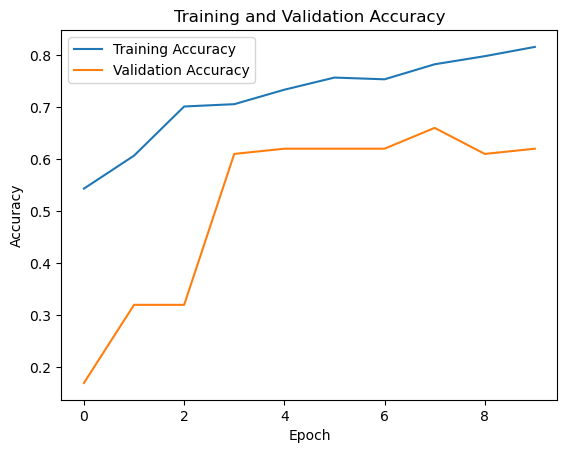

In [19]:
# Load pre-trained ResNet50 model (without top layers for feature extraction)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze pre-trained weights
base_model.trainable = False

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(10, activation='softmax')(x)  # 4 classes (Cloudy, Rainy, Shiny, Sunrise)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
# First, train only the custom layers
model.fit(train_generator, epochs=5, validation_data=test_generator, verbose=1)

# Unfreeze a smaller number of layers initially
for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_generator, epochs=10, validation_data=test_generator, verbose=1)

model.save('Corel1k.keras')

plt.plot(model.history.history['accuracy'], label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [8]:
model = load_model('Corel1k.keras')

In [9]:
# Assuming you have ground truth labels (y_true) and predicted labels (y_pred)
y_true = test_generator.classes
y_pred = model.predict(test_generator).argmax(axis=1)

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1score = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1score:.4f}")

C:\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step 
Precision: 0.5680
Recall: 0.6200
F1 Score: 0.5774


C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
# Compute precision, recall, and F1-score for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1score = f1_score(y_true, y_pred, average=None)

# Print class-wise metrics
for class_label in range(1, len(precision) + 1):
    print(f"Class {class_label}:")
    print(f"Precision: {precision[class_label - 1]:.4f}")
    print(f"Recall: {recall[class_label - 1]:.4f}")
    print(f"F1 Score: {f1score[class_label - 1]:.4f}\n")

# Print overall classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))


Class 1:
Precision: 0.3333
Recall: 0.2000
F1 Score: 0.2500

Class 2:
Precision: 0.6667
Recall: 1.0000
F1 Score: 0.8000

Class 3:
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Class 4:
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class 5:
Precision: 0.6667
Recall: 1.0000
F1 Score: 0.8000

Class 6:
Precision: 0.3500
Recall: 0.7000
F1 Score: 0.4667

Class 7:
Precision: 0.8000
Recall: 0.8000
F1 Score: 0.8000

Class 8:
Precision: 0.6250
Recall: 0.5000
F1 Score: 0.5556

Class 9:
Precision: 0.6667
Recall: 0.6000
F1 Score: 0.6316

Class 10:
Precision: 0.5714
Recall: 0.4000
F1 Score: 0.4706

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.20      0.25        10
           1       0.67      1.00      0.80        10
           2       1.00      1.00      1.00        10
           3       0.00      0.00      0.00        10
           4       0.67      1.00      0.80        10
           5       0.35      0.70      0.47        

C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: Unde

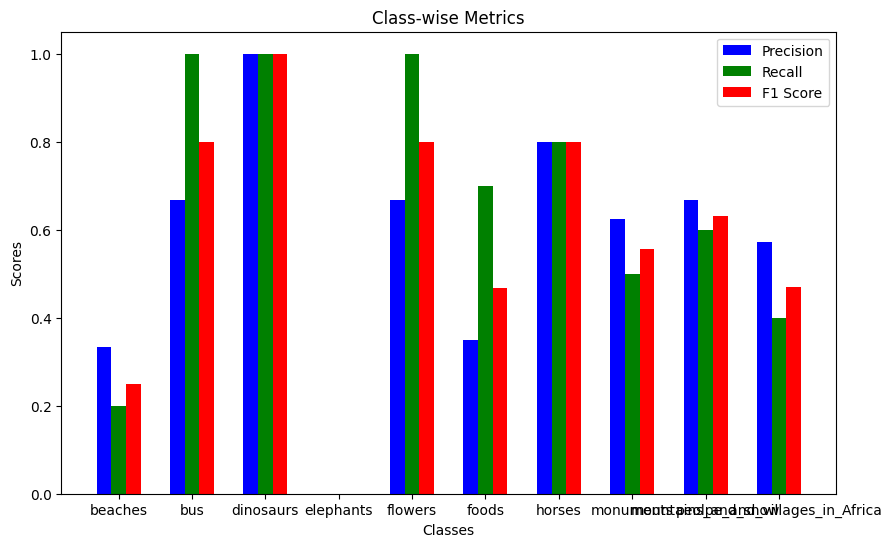

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace with your actual metrics)
classes = ['beaches', 'bus', 'dinosaurs', 'elephants', 'flowers','foods','horses','monuments','mountains_and_snow','peolpe_and_villages_in_Africa']

# Create subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Bar width
width = 0.2

# Plot bars
ax.bar(np.arange(len(classes)), precision, width, label='Precision', color='b')
ax.bar(np.arange(len(classes)) + width, recall, width, label='Recall', color='g')
ax.bar(np.arange(len(classes)) + 2 * width, f1score, width, label='F1 Score', color='r')

# Customize plot
ax.set_xticks(np.arange(len(classes)) + width)
ax.set_xticklabels(classes)
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Class-wise Metrics')
ax.legend()

# Show the plot
plt.show()


# CBIR

In [7]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from sklearn.preprocessing import normalize
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from pathlib import Path
from tensorflow.keras.models import load_model

In [2]:
model = load_model('Corel1k.keras')

In [14]:
dataset_path ='C:/Users/Madhusmita Das/Downloads/Corel/dataset/test_set'

# Extract The Feature Vector of All images

def extract_features(img_path, model):
  """
  Extracts features from an image using the pre-trained model.

  Args:
      img_path: Path to the image file.
      model: The pre-trained model (ResNet50 in this case).

  Returns:
      A normalized feature vector.
  """
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  features = features.flatten()
  features = normalize(features.reshape(1, -1))  # Normalize for distance calculation
  return features

all_features = {}
all_images = []

# Extract features for all images in the dataset
for class_dir in listdir(dataset_path):
    class_path = Path(dataset_path) / class_dir
    for img_file in listdir(class_path):
      img_path = Path(class_path) / img_file
      features = extract_features(img_path, model)
      all_features[img_path] = features
      all_images.append(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [1]:
def retrieve_similar_images(query_path, dataset_path, model, num_results=5):
  """
  Retrieves similar images from the dataset based on the query image.

  Args:
      query_path: Path to the query image.
      dataset_path: Path to the dataset folder.
      model: The pre-trained model.
      num_results: Number of similar images to retrieve (default: 5).

  Returns:
      A list of paths to the most similar images.
  """
  query_features = extract_features(query_path, model)
  # Calculate distances between query features and all image features
  distances = {}
  for img_path, features in all_features.items():
    distance = np.linalg.norm(query_features - features)
    distances[img_path] = distance

  # Sort images by distance (ascending order)
  sorted_images = sorted(distances.items(), key=lambda item: item[1], reverse=True)

  # Return paths to the most similar images
  return [path for path, _ in sorted_images[:num_results]]


def display_images(image_paths):
  cols = 3  # Adjust the number of columns as needed
  rows = int(len(image_paths) / cols) + (len(image_paths) % cols > 0)
  plt.figure(figsize=(15, 4 * rows))
  for i, image_path in enumerate(image_paths):
    plt.subplot(rows, cols, i + 1)
    img = image.load_img(image_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')
  plt.tight_layout()
  plt.show()

# Load your pre-trained model (assuming it's saved as 'my_model.h5')
# model = tf.keras.models.load_model('my_model.h5')

# Get the query image path     
query_path = 'C:/Users/Madhusmita Das/Downloads/Corel/dataset/training_set/horse/740.jpg'

# Retrieve similar images
similar_images = retrieve_similar_images(query_path, dataset_path, model)

# Display the query image and similar images
print("Query Image:")
plt.imshow(plt.imread(query_path))
plt.axis('off')
plt.show()

print("Similar Images:")
display_images(similar_images) 

NameError: name 'dataset_path' is not defined